In [5]:
import tensorflow as tf
import tf_mnist_loader
import numpy as np
import time
import random
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
dataset = tf_mnist_loader.read_data_sets("mnist_data")
save_dir = "checkPoint/"
save_prefix = "save"
summaryFolderName= "summary/"

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [7]:
if os.path.isdir(summaryFolderName) == False:
    os.mkdir(summaryFolderName)
if os.path.isdir(save_dir) == False:
    os.mkdir(save_dir)
start_step = 0
load_pth = save_dir + save_prefix + str(start_step) + ".ckpt"
eval_only = False
draw = 0
animate = 0
translateMnist = 1
eyeCentered = 0
preTraining = 1
preTraining_epoch = 20000
drawReconsturction = 1
MNIST_SIZE = 28
translated_img_size = 60
if translateMnist:
    print "Translating mnist"
    img_size = translated_img_size
    depth = 3
    sensorBandwidth = 12
    minRadius = 6 #  zooms -> minRadius*2**<depth_level>
    initLr = 5.0e-3
    lrDecayRate = 0.995
    lrDecayFreq = 500
    momentumValue = 0.9
    batch_size = 20
else:
    print "Center mnist"
    img_size = MNIST_SIZE
    depth = 1
    sensorBandwidth = 8
    minRadius = 4
    initLr = 5.0e-3
    lrDecayRate = 0.99
    lrDecayFreq = 200
    momentumValue = 0.9
    batch_size = 20

Translating mnist


In [8]:
# model parameters
channels = 1
totalSensorBandwidth = depth*channels*(sensorBandwidth**2)
nGlimpses = 6
loc_sd = 0.11
# network units
hg_size = 128
hl_size = 128
g_size = 256
cell_size = 256
cell_out_size = cell_size
# parameter about the training example
n_classes = 10
# training parameters
max_iters = 1000000
SMALL_NUM = 1e-10
# resource preallocation
mean_locs = []      # expectation of locations
sampled_locs = []   # sampled locations N(mean_locs[],loc_sd)
baselines = []      # baseline, the value prediction
glimpse_images = [] # to show in window

In [9]:
# set the weights to be small random values, with truncated normal distribution
def weight_variable(shape,name,train):
    init = tf.random_uniform(shape,minval = -0.1, maxval=0.1)
    return tf.Variable(init,name=name,trainable=train)

In [23]:
sess = tf.Session()
x  = np.random.randn(6,6)
x = tf.reshape(x,(1,6,6,1))
x= sess.run(tf.image.resize_bilinear(x,(12,12)))
x.shape
#sess.run(tf.tile(tf.constant(12,shape=[1]),[2]))

(1, 12, 12, 1)

In [285]:
# get local glimpese
def glimpseSensor(img, normLoc):
    loc = tf.round(((normLoc + 1) / 2.0) * img_size)  # normLoc coordinates are between -1 and 1
    loc = tf.cast(loc, tf.int32)

    img = tf.reshape(img, (batch_size, img_size, img_size, channels))

    # process each image individually
    zooms = []
    for k in xrange(batch_size):
        imgZooms = []
        one_img = img[k,:,:,:]
        max_radius = minRadius * (2 ** (depth - 1))
        offset = 2 * max_radius

        # pad image with zeros
        one_img = tf.image.pad_to_bounding_box(one_img, offset, offset, \
                                               max_radius * 4 + img_size, max_radius * 4 + img_size)

        for i in xrange(depth):
            r = int(minRadius * (2 ** (i)))

            d_raw = 2 * r
            d = tf.constant(d_raw, shape=[1])
            d = tf.tile(d, [2])
            loc_k = loc[k,:]
            adjusted_loc = offset + loc_k - r
            one_img2 = tf.reshape(one_img, (one_img.get_shape()[0].value, one_img.get_shape()[1].value))

            # crop image to (d x d)
            zoom = tf.slice(one_img2, adjusted_loc, d)

            # resize cropped image to (sensorBandwidth x sensorBandwidth)
            zoom = tf.image.resize_bilinear(tf.reshape(zoom, (1, d_raw, d_raw, 1)), (sensorBandwidth, sensorBandwidth))
            zoom = tf.reshape(zoom, (sensorBandwidth, sensorBandwidth))
            imgZooms.append(zoom)

        zooms.append(tf.stack(imgZooms))

    zooms = tf.stack(zooms)

    glimpse_images.append(zooms)

    return zooms

In [286]:
# implements the input network
def get_glimpse(loc):
    # get input using previous location
    glimpse_input = glimpseSensor(inputs_placeholder,loc)
    glimpse_input = tf.reshape(glimpse_input,(batch_size,totalSensorBandWidth))
    
    # the hidden units that process location $ the input
    act_glimpse_hidden = tf.nn.relu(tf.matmul(glimpse_input,Wg_g_h) + Bg_g_h)
    act_loc_hidden = tf.nn.relu(tf.matmul(loc, Wg_l_h) + Bg_l_h)

    # the hidden units that integrates the location & the glimpses
    glimpseFeature1 = tf.nn.relu(tf.matmul(act_glimpse_hidden, Wg_hg_gf1) + tf.matmul(act_loc_hidden, Wg_hl_gf1) + Bg_hlhg_gf1)
    # return g
    # glimpseFeature2 = tf.matmul(glimpseFeature1, Wg_gf1_gf2) + Bg_gf1_gf2
    return glimpseFeature1

In [287]:
def get_next_input(output):
    # the next location is computed by the location network
    baseline = tf.sigmoid(tf.matmul(output,Wb_h_b) + Bb_h_b)
    baselines.append(baseline)
    # compute the next location, then impose noise
    if eyeCentered:
        # add the last sampled glimpse location
        # TODO max(-1, min(1, u + N(output, sigma) + prevLoc))
        mean_loc = tf.maximum(-1.0, tf.minimum(1.0, tf.matmul(output, Wl_h_l) + sampled_locs[-1] ))
    else:
        mean_loc = tf.matmul(output, Wl_h_l)

    mean_loc = tf.stop_gradient(mean_loc)
    mean_locs.append(mean_loc)

    # add noise
    # sample_loc = tf.tanh(mean_loc + tf.random_normal(mean_loc.get_shape(), 0, loc_sd))
    sample_loc = tf.maximum(-1.0, tf.minimum(1.0, mean_loc + tf.random_normal(mean_loc.get_shape(), 0, loc_sd)))

    # don't propagate throught the locations
    sample_loc = tf.stop_gradient(sample_loc)
    sampled_locs.append(sample_loc)

    return get_glimpse(sample_loc)

In [288]:
def affineTransform(x,output_dim):
    """
    affine transformation Wx+b
    assumes x.shape = (batch_size, num_features)
    """
    w=tf.get_variable("w", [x.get_shape()[1], output_dim])
    b=tf.get_variable("b", [output_dim], initializer=tf.constant_initializer(0.0))
    return tf.matmul(x,w)+b

In [289]:
def model():
    # initialize the location under unif[-1,1], for all example in the batch
    initial_loc = tf.random_uniform((batch_size, 2), minval=-1, maxval=1)
    mean_locs.append(initial_loc)
    initial_loc = tf.tanh(initial_loc + tf.random_normal(initial_loc.get_shape(), 0, loc_sd))
    sampled_locs.append(initial_loc)

    # get the input using the input network
    initial_glimpse = get_glimpse(initial_loc)

    # set up the recurrent structure
    inputs = [0] * nGlimpses
    outputs = [0] * nGlimpses
    glimpse = initial_glimpse
    REUSE = None
    for t in range(nGlimpses):
        if t == 0:  # initialize the hidden state to be the zero vector
            hiddenState_prev = tf.zeros((batch_size, cell_size))
        else:
            hiddenState_prev = outputs[t-1]

        # forward prop
        with tf.variable_scope("coreNetwork", reuse=REUSE):
            # the next hidden state is a function of the previous hidden state and the current glimpse
            hiddenState = tf.nn.relu(affineTransform(hiddenState_prev, cell_size) + (tf.matmul(glimpse, Wc_g_h) + Bc_g_h))

        # save the current glimpse and the hidden state
        inputs[t] = glimpse
        outputs[t] = hiddenState
        # get the next input glimpse
        if t != nGlimpses -1:
            glimpse = get_next_input(hiddenState)
        else:
            baseline = tf.sigmoid(tf.matmul(hiddenState, Wb_h_b) + Bb_h_b)
            baselines.append(baseline)
        REUSE = True  # share variables for later recurrence

    return outputs

In [290]:
def dense_to_one_hot(label_dense,num_classes=10):
    """
    Convert class labels from scalars to one-hot vectors.
    """
    num_labels = label_dense.shape[0]
    index_offset = np.arange(num_labels)*num_classes
    labels_one_hot = np.zeros((num_labels,num_classes))
    labels_one_hot.flat[index_offset + label_dense.ravel()] = 1
    return labels_one_hot

In [291]:
# to use for maximum likelihood with input location
def gaussian_pdf(mean,sample):
    Z = 1.0 / (loc_sd * tf.sqrt(2.0 * np.pi))
    a = -tf.square(sample - mean) / (2.0 * tf.square(loc_sd))
    return Z * tf.exp(a)

In [292]:
def calc_reward(outputs):
    # consider the action at the last time step
    outputs = outputs[-1] # look at ONLY THE END of the sequence
    outputs = tf.reshape(outputs,(batch_size,cell_out_size))
    
    # get the baseline
    b = tf.stack(baselines)
    b = tf.concat(axis=2, values=[b,b])
    b = tf.reshape(b,(batch_size,(nGlimpses)*2))
    no_grad_b = tf.stop_gradient(b)
    
    # get the action(classification)
    p_y = tf.nn.softmax(tf.matmul(outputs,Wa_h_a) + Ba_h_a)
    max_p_y = tf.arg_max(p_y,1)
    correct_y = tf.cast(labels_placeholder, tf.int64)
    
    # reward for all examples in the batch
    R = tf.cast(tf.equal(max_p_y,correct_y),tf.float32)
    reward = tf.reduce_mean(R) # mean reward
    R = tf.reshape(R,(batch_size,1))
    R = tf.tile(R,[1,(nGlimpses)*2])
    
    # get the location
    p_loc = gaussian_pdf(mean_locs, sampled_locs)
    p_loc = tf.tanh(p_loc)
    p_loc_orig = p_loc
    p_loc = tf.reshape(p_loc, (batch_size, (nGlimpses) * 2))

    # define the cost function
    J = tf.concat(axis=1, values=[tf.log(p_y + SMALL_NUM) * (onehot_labels_placeholder), tf.log(p_loc + SMALL_NUM) * (R - no_grad_b)])
    J = tf.reduce_sum(J, 1)
    J = J - tf.reduce_sum(tf.square(R - b), 1)
    J = tf.reduce_mean(J, 0)
    cost = -J

    # define the optimizer
    optimizer = tf.train.MomentumOptimizer(lr, momentumValue)
    train_op = optimizer.minimize(cost, global_step)

    return cost, reward, max_p_y, correct_y, train_op, b, tf.reduce_mean(b), tf.reduce_mean(R - b), lr
    
    

In [293]:
def preTrain(outputs):
    lr_r = 1e-3
    # consider the action at the last time step
    outputs = outputs[-1] # look at ONLY THE END of the sequence
    outputs = tf.reshape(outputs, (batch_size, cell_out_size))
    # if preTraining:
    reconstruction = tf.sigmoid(tf.matmul(outputs, Wr_h_r) + Br_h_r)
    reconstructionCost = tf.reduce_mean(tf.square(inputs_placeholder - reconstruction))

    train_op_r = tf.train.RMSPropOptimizer(lr_r).minimize(reconstructionCost)
    return reconstructionCost, reconstruction, train_op_r

In [294]:
def evaluate():
    data = dataset.test
    batches_in_epoch = len(data._images) // batch_size
    accuracy = 0

    for i in xrange(batches_in_epoch):
        nextX, nextY = dataset.test.next_batch(batch_size)
        if translateMnist:
            nextX, _ = convertTranslated(nextX, MNIST_SIZE, img_size)
        feed_dict = {inputs_placeholder: nextX, labels_placeholder: nextY,
                     onehot_labels_placeholder: dense_to_one_hot(nextY)}
        r = sess.run(reward, feed_dict=feed_dict)
        accuracy += r

    accuracy /= batches_in_epoch
    print("ACCURACY: " + str(accuracy))

In [295]:
def convertTranslated(images, initImgSize, finalImgSize):
    size_diff = finalImgSize - initImgSize
    newimages = np.zeros([batch_size, finalImgSize*finalImgSize])
    imgCoord = np.zeros([batch_size,2])
    for k in xrange(batch_size):
        image = images[k, :]
        image = np.reshape(image, (initImgSize, initImgSize))
        # generate and save random coordinates
        randX = random.randint(0, size_diff)
        randY = random.randint(0, size_diff)
        imgCoord[k,:] = np.array([randX, randY])
        # padding
        image = np.lib.pad(image, ((randX, size_diff - randX), (randY, size_diff - randY)), 'constant', constant_values = (0))
        newimages[k, :] = np.reshape(image, (finalImgSize*finalImgSize))

    return newimages, imgCoord

In [296]:
def toMnistCoordinates(coordinate_tanh):
    '''
    Transform coordinate in [-1,1] to mnist
    :param coordinate_tanh: vector in [-1,1] x [-1,1]
    :return: vector in the corresponding mnist coordinate
    '''
    return np.round(((coordinate_tanh + 1) / 2.0) * img_size)

In [297]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('param_summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('param_mean/' + name, mean)
        with tf.name_scope('param_stddev'):
            stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
        tf.summary.scalar('param_sttdev/' + name, stddev)
        tf.summary.scalar('param_max/' + name, tf.reduce_max(var))
        tf.summary.scalar('param_min/' + name, tf.reduce_min(var))
        tf.summary.histogram(name, var)

In [298]:
def plotWholeImg(img, img_size, sampled_locs_fetched):
    plt.imshow(np.reshape(img, [img_size, img_size]),
               cmap=plt.get_cmap('gray'), interpolation="nearest")

    plt.ylim((img_size - 1, 0))
    plt.xlim((0, img_size - 1))

    # transform the coordinate to mnist map
    sampled_locs_mnist_fetched = toMnistCoordinates(sampled_locs_fetched)
    # visualize the trace of successive nGlimpses (note that x and y coordinates are "flipped")
    plt.plot(sampled_locs_mnist_fetched[0, :, 1], sampled_locs_mnist_fetched[0, :, 0], '-o',
             color='lawngreen')
    plt.plot(sampled_locs_mnist_fetched[0, -1, 1], sampled_locs_mnist_fetched[0, -1, 0], 'o',
             color='red')

INFO:tensorflow:Summary name mean(b) is illegal; using mean_b_ instead.


INFO:tensorflow:Summary name mean(b) is illegal; using mean_b_ instead.


INFO:tensorflow:Summary name mean(R - b) is illegal; using mean_R_-_b_ instead.


INFO:tensorflow:Summary name mean(R - b) is illegal; using mean_R_-_b_ instead.


Step 20: reconstructionCost = 0.24709
Step 40: reconstructionCost = 0.24693
Step 60: reconstructionCost = 0.24711
Step 80: reconstructionCost = 0.24666
Step 100: reconstructionCost = 0.24694
Step 120: reconstructionCost = 0.24592
Step 140: reconstructionCost = 0.24392
Step 160: reconstructionCost = 0.21926
Step 180: reconstructionCost = 0.04257
Step 200: reconstructionCost = 0.02664
Step 220: reconstructionCost = 0.02934
Step 240: reconstructionCost = 0.02566
Step 260: reconstructionCost = 0.02427
Step 280: reconstructionCost = 0.02457
Step 300: reconstructionCost = 0.02545
Step 320: reconstructionCost = 0.02658
Step 340: reconstructionCost = 0.02574
Step 360: reconstructionCost = 0.02487
Step 380: reconstructionCost = 0.02374
Step 400: reconstructionCost = 0.02791
Step 420: reconstructionCost = 0.02161
Step 440: reconstructionCost = 0.02114
Step 460: reconstructionCost = 0.02528
Step 480: reconstructionCost = 0.01953
Step 500: reconstructionCost = 0.01777
Step 520: reconstructionCost 

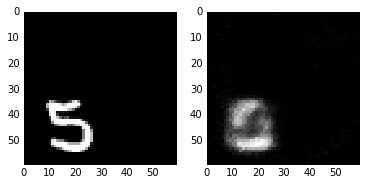

In [299]:
with tf.Graph().as_default():

    # set the learning rate
    global_step = tf.Variable(0, trainable=False)
    lr = tf.train.exponential_decay(initLr, global_step, lrDecayFreq, lrDecayRate, staircase=True)

    # preallocate x, y, baseline
    labels = tf.placeholder("float32", shape=[batch_size, n_classes])
    labels_placeholder = tf.placeholder(tf.float32, shape=(batch_size), name="labels_raw")
    onehot_labels_placeholder = tf.placeholder(tf.float32, shape=(batch_size, 10), name="labels_onehot")
    inputs_placeholder = tf.placeholder(tf.float32, shape=(batch_size, img_size * img_size), name="images")

    # declare the model parameters, here're naming rule:
    # the 1st captical letter: weights or bias (W = weights, B = bias)
    # the 2nd lowercase letter: the network (e.g.: g = glimpse network)
    # the 3rd and 4th letter(s): input-output mapping, which is clearly written in the variable name argument

    Wg_l_h = weight_variable((2, hl_size), "glimpseNet_wts_location_hidden", True)
    Bg_l_h = weight_variable((1,hl_size), "glimpseNet_bias_location_hidden", True)

    Wg_g_h = weight_variable((totalSensorBandwidth, hg_size), "glimpseNet_wts_glimpse_hidden", True)
    Bg_g_h = weight_variable((1,hg_size), "glimpseNet_bias_glimpse_hidden", True)

    Wg_hg_gf1 = weight_variable((hg_size, g_size), "glimpseNet_wts_hiddenGlimpse_glimpseFeature1", True)
    Wg_hl_gf1 = weight_variable((hl_size, g_size), "glimpseNet_wts_hiddenLocation_glimpseFeature1", True)
    Bg_hlhg_gf1 = weight_variable((1,g_size), "glimpseNet_bias_hGlimpse_hLocs_glimpseFeature1", True)

    Wc_g_h = weight_variable((cell_size, g_size), "coreNet_wts_glimpse_hidden", True)
    Bc_g_h = weight_variable((1,g_size), "coreNet_bias_glimpse_hidden", True)

    Wr_h_r = weight_variable((cell_out_size, img_size**2), "reconstructionNet_wts_hidden_action", True)
    Br_h_r = weight_variable((1, img_size**2), "reconstructionNet_bias_hidden_action", True)

    Wb_h_b = weight_variable((g_size, 1), "baselineNet_wts_hiddenState_baseline", True)
    Bb_h_b = weight_variable((1,1), "baselineNet_bias_hiddenState_baseline", True)

    Wl_h_l = weight_variable((cell_out_size, 2), "locationNet_wts_hidden_location", True)

    Wa_h_a = weight_variable((cell_out_size, n_classes), "actionNet_wts_hidden_action", True)
    Ba_h_a = weight_variable((1,n_classes),  "actionNet_bias_hidden_action", True)

    # query the model ouput
    outputs = model()

    # convert list of tensors to one big tensor
    sampled_locs = tf.concat(axis=0, values=sampled_locs)
    sampled_locs = tf.reshape(sampled_locs, (nGlimpses, batch_size, 2))
    sampled_locs = tf.transpose(sampled_locs, [1, 0, 2])
    mean_locs = tf.concat(axis=0, values=mean_locs)
    mean_locs = tf.reshape(mean_locs, (nGlimpses, batch_size, 2))
    mean_locs = tf.transpose(mean_locs, [1, 0, 2])
    glimpse_images = tf.concat(axis=0, values=glimpse_images)



    # compute the reward
    reconstructionCost, reconstruction, train_op_r = preTrain(outputs)
    cost, reward, predicted_labels, correct_labels, train_op, b, avg_b, rminusb, lr = calc_reward(outputs)

    # tensorboard visualization for the parameters
    variable_summaries(Wg_l_h, "glimpseNet_wts_location_hidden")
    variable_summaries(Bg_l_h, "glimpseNet_bias_location_hidden")
    variable_summaries(Wg_g_h, "glimpseNet_wts_glimpse_hidden")
    variable_summaries(Bg_g_h, "glimpseNet_bias_glimpse_hidden")
    variable_summaries(Wg_hg_gf1, "glimpseNet_wts_hiddenGlimpse_glimpseFeature1")
    variable_summaries(Wg_hl_gf1, "glimpseNet_wts_hiddenLocation_glimpseFeature1")
    variable_summaries(Bg_hlhg_gf1, "glimpseNet_bias_hGlimpse_hLocs_glimpseFeature1")

    variable_summaries(Wc_g_h, "coreNet_wts_glimpse_hidden")
    variable_summaries(Bc_g_h, "coreNet_bias_glimpse_hidden")

    variable_summaries(Wb_h_b, "baselineNet_wts_hiddenState_baseline")
    variable_summaries(Bb_h_b, "baselineNet_bias_hiddenState_baseline")

    variable_summaries(Wl_h_l, "locationNet_wts_hidden_location")

    variable_summaries(Wa_h_a, 'actionNet_wts_hidden_action')
    variable_summaries(Ba_h_a, 'actionNet_bias_hidden_action')

    # tensorboard visualization for the performance metrics
    tf.summary.scalar("reconstructionCost", reconstructionCost)
    tf.summary.scalar("reward", reward)
    tf.summary.scalar("cost", cost)
    tf.summary.scalar("mean(b)", avg_b)
    tf.summary.scalar("mean(R - b)", rminusb)
    summary_op = tf.summary.merge_all()


    ####################################### START RUNNING THE MODEL #######################################
    sess = tf.Session()
    saver = tf.train.Saver()
    b_fetched = np.zeros((batch_size, (nGlimpses)*2))

    init = tf.global_variables_initializer()
    sess.run(init)

    if eval_only:
        evaluate()
    else:
        summary_writer = tf.summary.FileWriter(summaryFolderName, graph=sess.graph)

        if draw:
            fig = plt.figure(1)
            txt = fig.suptitle("-", fontsize=36, fontweight='bold')
            plt.ion()
            plt.show()
            plt.subplots_adjust(top=0.7)
            plotImgs = []

        if drawReconsturction:
            fig = plt.figure(2)
            txt = fig.suptitle("-", fontsize=36, fontweight='bold')
            plt.ion()
            plt.show()

        if preTraining:
            for epoch_r in xrange(1,preTraining_epoch):
                nextX, _ = dataset.train.next_batch(batch_size)
                nextX_orig = nextX
                if translateMnist:
                    nextX, _ = convertTranslated(nextX, MNIST_SIZE, img_size)

                fetches_r = [reconstructionCost, reconstruction, train_op_r]

                reconstructionCost_fetched, reconstruction_fetched, train_op_r_fetched = sess.run(fetches_r, feed_dict={inputs_placeholder: nextX})

                if epoch_r % 20 == 0:
                    print('Step %d: reconstructionCost = %.5f' % (epoch_r, reconstructionCost_fetched))
                    if epoch_r % 100 == 0:
                        if drawReconsturction:
                            fig = plt.figure(2)

                            plt.subplot(1, 2, 1)
                            plt.imshow(np.reshape(nextX[0, :], [img_size, img_size]),
                                       cmap=plt.get_cmap('gray'), interpolation="nearest")
                            plt.ylim((img_size - 1, 0))
                            plt.xlim((0, img_size - 1))

                            plt.subplot(1, 2, 2)
                            plt.imshow(np.reshape(reconstruction_fetched[0, :], [img_size, img_size]),
                                       cmap=plt.get_cmap('gray'), interpolation="nearest")
                            plt.ylim((img_size - 1, 0))
                            plt.xlim((0, img_size - 1))
                            plt.draw()
                            plt.pause(0.0001)
                            # plt.show()


        # training
        for epoch in xrange(start_step + 1, max_iters):
            start_time = time.time()

            # get the next batch of examples
            nextX, nextY = dataset.train.next_batch(batch_size)
            nextX_orig = nextX
            if translateMnist:
                nextX, nextX_coord = convertTranslated(nextX, MNIST_SIZE, img_size)

            feed_dict = {inputs_placeholder: nextX, labels_placeholder: nextY, \
                         onehot_labels_placeholder: dense_to_one_hot(nextY)}

            fetches = [train_op, cost, reward, predicted_labels, correct_labels, glimpse_images, avg_b, rminusb, \
                       mean_locs, sampled_locs, lr]
            # feed them to the model
            results = sess.run(fetches, feed_dict=feed_dict)

            _, cost_fetched, reward_fetched, prediction_labels_fetched, correct_labels_fetched, glimpse_images_fetched, \
            avg_b_fetched, rminusb_fetched, mean_locs_fetched, sampled_locs_fetched, lr_fetched = results


            duration = time.time() - start_time

            if epoch % 20 == 0:
                print('Step %d: cost = %.5f reward = %.5f (%.3f sec) b = %.5f R-b = %.5f, LR = %.5f'
                      % (epoch, cost_fetched, reward_fetched, duration, avg_b_fetched, rminusb_fetched, lr_fetched))
                summary_str = sess.run(summary_op, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, epoch)
                # if saveImgs:
                #     plt.savefig(imgsFolderName + simulationName + '_ep%.6d.png' % (epoch))

                if epoch % 5000 == 0:
                    saver.save(sess, save_dir + save_prefix + str(epoch) + ".ckpt")
                    evaluate()

                ##### DRAW WINDOW ################
                f_glimpse_images = np.reshape(glimpse_images_fetched, \
                                              (nGlimpses, batch_size, depth, sensorBandwidth, sensorBandwidth))

                if draw:
                    if animate:
                        fillList = False
                        if len(plotImgs) == 0:
                            fillList = True

                        # display the first image in the in mini-batch
                        nCols = depth+1
                        plt.subplot2grid((depth, nCols), (0, 1), rowspan=depth, colspan=depth)
                        # display the entire image
                        plotWholeImg(nextX[0, :], img_size, sampled_locs_fetched)

                        # display the glimpses
                        for y in xrange(nGlimpses):
                            txt.set_text('Epoch: %.6d \nPrediction: %i -- Truth: %i\nStep: %i/%i'
                                         % (epoch, prediction_labels_fetched[0], correct_labels_fetched[0], (y + 1), nGlimpses))

                            for x in xrange(depth):
                                plt.subplot(depth, nCols, 1 + nCols * x)
                                if fillList:
                                    plotImg = plt.imshow(f_glimpse_images[y, 0, x], cmap=plt.get_cmap('gray'),
                                                         interpolation="nearest")
                                    plotImg.autoscale()
                                    plotImgs.append(plotImg)
                                else:
                                    plotImgs[x].set_data(f_glimpse_images[y, 0, x])
                                    plotImgs[x].autoscale()
                            fillList = False

                            # fig.canvas.draw()
                            time.sleep(0.1)
                            plt.pause(0.00005)

                    else:
                        txt.set_text('PREDICTION: %i\nTRUTH: %i' % (prediction_labels_fetched[0], correct_labels_fetched[0]))
                        for x in xrange(depth):
                            for y in xrange(nGlimpses):
                                plt.subplot(depth, nGlimpses, x * nGlimpses + y + 1)
                                plt.imshow(f_glimpse_images[y, 0, x], cmap=plt.get_cmap('gray'), interpolation="nearest")

                        plt.draw()
                        time.sleep(0.05)
                        plt.pause(0.0001)

    sess.close()

In [300]:
sess = tf.Session()
sess.run(tf.tile(tf.reshape(tf.constant([1,2,3]),(3,1)),[2,4]))

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]], dtype=int32)